# OQT and ohsome API 

Previously we did two things:
- requested the *ohsome API* to get statistics on our desired **topic** by filtering OSM data using OSM tags (e.g. `building=* and geometry:polygon and building!=no`).
- requested the *OQT API* to get qualtiy estimation on our desired **topic** by providing a layer name. 

OQT uses the ohsome API to retrive statistics for making quality estimations. OQT translates the layer name to a fitting ohsome API query inlcuding the type of aggregation and the filter.


## What if OQT does not provide the **topic** of interest as a layer?

The Mapping Saturation Indicator needs the counts (or length) of features at particular timeintervals to find the best fitting curve to describe the saturation. It takes a list of those data points as input:

```python
[
    {
        "timestamp": "2014-01-01T00:00:00Z",
        "value": 432.0  # number of features
    },
    ...
]
```

The similarity of above example to the ohsome API response is no accident.

It is possible to send those data points directly to OQT which then computes the Mapping Saturation Indicator for those instead of quering the ohsome API. Lets see how to do this!

### Let's try it first with the ohsome Dashboard
The [ohsome Dashboard](https://ohsome.org/apps/dashboard/) generates accurate statistics about the historical development of OSM data for custom or predefined regions all over the world and relies on the ohsome API. No programming skills are needed to work with the dashboard. The ohsome Dashboard allows custom filtering of all available OpenStreetMap tags and types and includes administrative boundaries, making the selection of search areas easier. As a result you get a graphical view on the response values of your request.

1. Define your query in the dashboard.
<img src="img/ohsome_dashboard_cycleways_query.png" width="75%">

2. Take a look at the results.
<img src="img/ohsome_dashboard_cycleways_results.png" width="75%">

In [2]:
# Helper function to display results.

import json

from IPython.display import SVG, display
import requests
from termcolor import colored
import matplotlib.pyplot as plt


def display_oqt_results(feature):
    name = feature["properties"]["name"]
    label = feature["properties"]["result"]["label"]
    color = feature["properties"]["result"]["label"]
    description = feature["properties"]["result"]["description"]
    svg = feature["properties"]["result"]["svg"]

    # print(json.dumps(result, indent=4))
    print(name)
    print("-" * len(name))
    print("Quality Label: " + colored(label, color))
    print("Result Description: " + description)
    display(SVG(svg))
    
    
def display_ohsome_results(result):
    dates = []
    values = []
    for r in result:
        year = datetime.fromisoformat(r["timestamp"].replace("Z", ""))
        dates.append(year)
        values.append(r["value"])

    fig, ax = plt.subplots()
    ax.plot(dates, values, label="highway=cycleway")
    ax.legend()
    fig.suptitle("Temporal Evolution of Cycleways")
    plt.show()

## Mapping Saturation of Cycleways

Remember our request made to the ohsome API to retrive number of features tagged as `(highway=cycleway or cycleway:both=* or cycleway:left=* or cycleway:right=*) and geometry:line`?

Lets use the response to compute the Mapping Saturation Indicator via the OQT API.

### Request the ohsome API

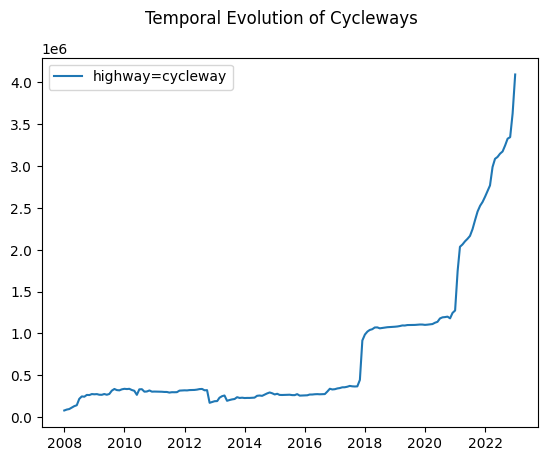

In [5]:
# The same code as in 00-ohsome.ipynb

import json

from datetime import datetime

import requests


base_url = "https://api.ohsome.org/v1"
endpoint = "/elements/length"
url = base_url + endpoint

with open("germany-berlin.geojson", "r") as file:
    bpolys = json.load(file)

parameters = {
    "bpolys": json.dumps(bpolys),  # pass GeoJSON as string.
    "filter": "(highway=cycleway or cycleway:both=* or cycleway:left=* or cycleway:right=*) and geometry:line",
    "format": "json",
    "time": "2008-01-01/2023-01-01/P1M",
}
headers = {
    "accept": "application/json",
    "Content-Type": "application/x-www-form-urlencoded",
}
    
response = requests.post(url, data=parameters, headers=headers)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

ohsome_result = response.json()["result"]
display_ohsome_results(ohsome_result)

### Request the OQT API

Berlin
------
Quality Label: yellow
Result Description: The saturation of the last 3 years is 47.76%.
Saturation is in progress (30% < Saturation ≤ 97%).



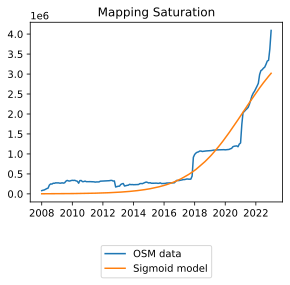

In [6]:
import json

import requests


base_url = "https://oqt.ohsome.org/api"
endpoint = "/indicator"
url = base_url + endpoint

with open("germany-berlin.geojson", "r") as file:
    bpolys = json.load(file)

# Define own layer
layer = {
    "name": "Cycleways",
    "description": "Number of features taged as `(highway=cycleway or cycleway:both=* or cycleway:left=* or cycleway:right=*) and geometry:line`.",
    "data": {"result": ohsome_result}
}

parameters = {
    "name": "MappingSaturation",
    "layer": layer,
    "bpolys": bpolys,
    "includeSvg": True,
}
response = requests.post(url, json=parameters)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

oqt_result = response.json()
display_oqt_results(oqt_result)

### Mapping Saturation Indicator for all districts in Berlin

The previous requests have been about one Area-of-Interest (AOI). OQT can compute the same Indicator for a number of AOIs given a GeoJSON FeatureCollection.

In [21]:
import json
from datetime import datetime
import requests


base_url = "https://api.ohsome.org/v1"
endpoint = "/elements/length/groupBy/boundary"
url = base_url + endpoint

# load districts as GeoJSON FeatureCollection
with open("germany-berlin-districts.geojson", "r") as file:
    bpolys = json.load(file)
    
parameters = {
    "bpolys": json.dumps(bpolys),  # pass GeoJSON as string.
    "filter": "(highway=cycleway or cycleway:both=* or cycleway:left=* or cycleway:right=*) and geometry:line",
    "format": "json",
    "time": "2008-01-01/2023-01-01/P1M",
}
headers = {
    "accept": "application/json",
    "Content-Type": "application/x-www-form-urlencoded",
}
    
response = requests.post(url, data=parameters, headers=headers)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

ohsome_result = response.json()["groupByResult"]

In [24]:
base_url = "https://oqt.ohsome.org/api"
endpoint = "/indicator"
url = base_url + endpoint

with open("germany-berlin-districts.geojson", "r") as file:
    bpolys = json.load(file)

# Define own layer
layer = {
    "name": "Cycleways",
    "description": "Number of features taged as `(highway=cycleway or cycleway:both=* or cycleway:left=* or cycleway:right=*) and geometry:line`.",
    "data": {"result": ohsome_result}
}

parameters = {
    "name": "MappingSaturation",
    "layer": layer,
    "bpolys": bpolys,
    "includeSvg": True,
}
response = requests.post(url, json=parameters)
response.raise_for_status()  # Raise an Exception if HTTP Status Code is not 200

features = response.json()["features"]
for feature in features:
    display_oqt_results(feature)

HTTPError: 422 Client Error: Unprocessable Entity for url: https://oqt.ohsome.org/api/indicator